## Introduction

#### Author - Chaman Gupta

Install the following libraries by copying each line to your command prompt/terminal:

***
`pip install ipywidgets IPython numpy pandas matplotlib scipy pybaselines peakutils tqdm`
***

### Import Libraries

In [1]:
# Import libraries
import os
from ipywidgets import *
from IPython.display import display, clear_output

import numpy as np
import pandas as pd
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from scipy.signal import find_peaks
from tqdm import tqdm

from helpers.helpers import *
from data_reader.datareader import DataReader
from intensity_correction.intensitycorrection import i_corr
from select_button.selectfilesbutton import SelectFilesButton
from plot_config import plot_config
from conversion_table.conversion_table import conversion_table
from peak_find.find_plot_peaks import find_and_plot_peaks

### Clean Intensity Correction files

In [2]:
do_lamp_cleaning = 'n' # y or n

if do_lamp_cleaning == 'y':
    print("\nSelect lamp files for cleaning and analysis \n(optional; if none is chosen, default intensity correction factor will be used): ")
    selectiCorrFiles = SelectFilesButton()
    display(selectiCorrFiles)
else:
    pass


In [3]:
## Variables
do_baseline_subtraction = 'n' # 'y', 'n'
do_median_filtering = 'n' # 'y', 'n'
do_data_cleaning = 'n' # 'y', 'n'
do_savgol_filtering = 'n' # 'y', 'n'
do_conversion = 'n' # 'raman', 'energy', 'n'
do_normalize = 'n' # 'relative' scale', 'area', 'n'
do_peak_finding = 'n' # 'y', 'n'

c_vac = 2.99*10**8 # speed of light in vacuum m/sec
laser_source = 532.03 # Excitation source in nm

p_order = 5 # Polynomial order for baseline subtraction
k_size = 7 # Kernel size for Median Filtering
erp = -10
k_size_savgol = 11
p_order_savgol = 1

In [4]:
if do_lamp_cleaning == 'y':
    i_corr_cleaning(selectiCorrFiles,do_baseline_subtraction,do_median_filtering,do_data_cleaning,do_savgol_filtering,do_conversion,do_normalize,do_peak_finding,p_order,k_size,erp,k_size_savgol,p_order_savgol)
else:
    pass

## Files for averaging and cosmic ray cleaning

In [5]:
print("Select data files to remove cosmic rays or average: ")
cleanFiles = SelectFilesButton()
display(cleanFiles)

Select data files to remove cosmic rays or average: 


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

### Cosmic Ray Removal and Averaging

In [6]:
do_cosmic_rays_removal = 'n'
if do_cosmic_rays_removal == 'y':
    x_data, cosmic_removed_data, averaged_data = remove_cosmic_rays(cleanFiles,batching=True,batch_size=3,average=True)
    print("cosmic rays removed")
        
    plt.plot(x_data,cosmic_removed_data)
    if len(averaged_data) > 0:
        plt.plot(x_data,averaged_data, color='red', linewidth=2, linestyle='--', label='Averaged')
    plt.show()

do_data_averaging = 'n'
if do_data_averaging == 'y':
    x_data, averaged_data = data_averaging(cleanFiles,average=True,batching=True,batch_size=5)
    print("data averaged")
        
    plt.plot(x_data,averaged_data)
    plt.show()

## Manual Intensity Correction

In [7]:
print("Select data files you want to analyze: ")
selectFiles = SelectFilesButton()
display(selectFiles)

do_intensity_correction = 'n'

if do_intensity_correction == 'y':
    print("\nSelect tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction \n(optional; if none is chosen, default intensity correction factor will be used): ")
    selectHalLamp = SelectFilesButton()
    display(selectHalLamp)
else:
    pass

Select data files you want to analyze: 


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

## Main Data Processing and Plotting

In [8]:
## Variables
is_fitted_data_file = False # 'y', 'n'
do_baseline_subtraction = 'n' # 'y', 'n'
do_median_filtering = 'n' # 'y', 'n'
do_data_cleaning = 'n' # 'y', 'n'
do_savgol_filtering = 'n' # 'y', 'n'
do_conversion = 'wavelength' # 'raman', 'energy', 'n'
do_normalize = 'n' # 'relative' scale', 'area', 'n'
do_peak_finding = 'n' # 'y', 'n'
do_slicing = 'n'
do_mfv_calc = 'n'
do_data_averaging = 'n'

hf = 20
p_order = 5 # Polynomial order for baseline subtraction
k_size = 7 # Kernel size for Median Filtering
erp = -5
k_size_savgol = 3
p_order_savgol = 1

start_x = 830
end_x = 1020

base = 0

c_vac = 2.99*10**8 # speed of light in vacuum m/sec
laser_source = 532.109 # Excitation source in nm 

100%|██████████| 2/2 [00:00<00:00, 37.74it/s]


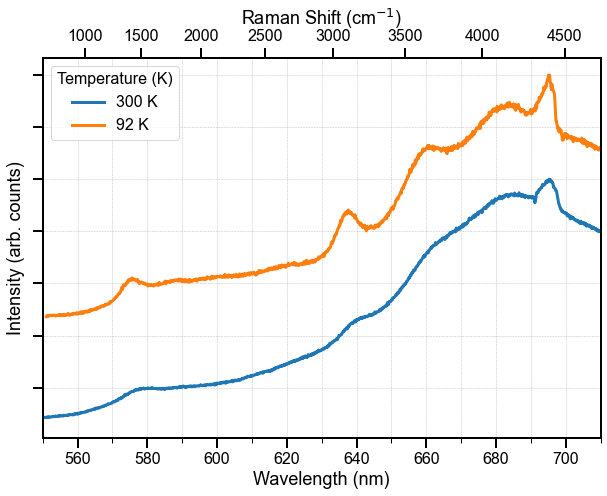

In [10]:
fdata = selectFiles.files

if do_intensity_correction == 'y': flamp = selectHalLamp.files

lab = ['300 K', '92 K']
color_lab = ['k','b']
power_lab = []

fig1 = plt.figure(figsize=(10,7)) # Put this outside loop if you want only one plot with all
# cruves. Keep it inside if you want separate plots
ax1 = fig1.add_subplot(111) # Put this outside loop if you want only one plot with all cruves. Keep it inside if you want separate plots

for i in tqdm(range(len(fdata))):
    
    # fig1 = plt.figure(figsize=(14,7))
    # ax1 = fig1.add_subplot(111) # Put this outside loop if you want only one plot with all cruves. Keep it inside if you want separate plots

    head_i, tail_i = os.path.split(fdata[i])
    
    x_data, y_data, metadata = DataReader(file_name=fdata[i]).read_file()
    
    # print(metadata)
    if do_intensity_correction == 'y': x_data, y_data, intens_data = i_corr(flamp, fdata, i, save_correction=False)
    else: intens_data = y_data

    if do_slicing == 'y': x_data, y_data, intens_data, start, end = slicing_func(x_data,y_data,intens_data,start_x,end_x)

    norm_intens_data = norm_func(x_data,y_data,do_normalize)
    
    if do_median_filtering == 'y': filt_data = filter_median(norm_intens_data, k_size)
    else: filt_data = norm_intens_data

    if do_baseline_subtraction == 'y':
        base = subtract_bsl(x_data,filt_data,hf)
        bsl_subt_data = filt_data - base
    else : bsl_subt_data = filt_data

    if do_data_cleaning == 'y': cleaned_data = data_cleaning(bsl_subt_data, erp)
    else: cleaned_data = bsl_subt_data

    if do_savgol_filtering == 'y': savgol_filt_data = filter_savgol(cleaned_data, k_size_savgol,p_order_savgol)
    else: savgol_filt_data = cleaned_data

    # Use the dictionary to look up actions based on do_conversion
    actions = conversion_table.get(do_conversion, conversion_table['wavelength'])

    x_val = actions['x_val'](x_data, laser_source)
    x_label = actions['x_label']
    y_val = actions['y_val'](savgol_filt_data, x_data)

    ### Peak Finding    
    if do_peak_finding == 'y': find_and_plot_peaks(ax1, x_val, y_val, savgol_filt_data, do_peak_finding='y', w_size=10, p_prom=2, thresh=2) # Call the function to find and plot peaks

    if is_fitted_data_file:
        
        #The 'lab' is a list to store the labels for locations of peaks. Add or remove based on how many peaks you have in your fitted data file from Fityk.
        
        color_lab = []
        power_lab = []
        lab = [581.686, 584.188, 587.87]
        color_len = metadata['col_len']
        
        ax1.scatter(x_data, y_data[:,0]/np.max(y_data[:,0]), marker='o', s=8, 
                    alpha=0.8,color='r')
        
        for j in range(1,color_len-2):
            
            #Plot wihtout lables
            ax1.plot(x_data, y_data[:,j]/np.max(y_data[:,0]), lw=1,color='b')
            
            #Plot with labels
            # ax1.plot(x_data, y_data[:,j]/np.max(y_data[:,0]), lw=0.8,color='k', label=str(lab[j-1]) + " nm -- " + str.format('{0:.1f}',nm2ram(lab[j-1])) + " cm$^{-1}$")
            
        ax1.plot(x_data, y_data[:,-1]/np.max(y_data[:,0]), lw=4, color='k')
    else:
        
        y_per = y_val
                
        ax1.plot(x_val, i*0.4 + y_per/np.max(y_per), lw=3, label=lab[i]) # Code line to plot the curves
        
# General plot properties are set below
# ax1.set_title(f'{tail_i}')
ax1.set_xlabel(x_label)

ax1.set_ylabel('Intensity (arb. counts)')
ax1.set_xlim(550,710)
ax1.legend(loc='upper left',title='Temperature (K)')
# ax1.set_ylim(0.25,0.295)
ax1.grid(True, which='both', linestyle='--')

# ax1.set_yticks([])
ax1.set_yticklabels([])

# ax1.tick_params(axis='y',which='both',left='off',labelleft='off')

ax1.xaxis.set_major_locator(MultipleLocator(20))
ax1.xaxis.set_major_formatter('{x:.0f}')
ax1.xaxis.set_minor_locator(MultipleLocator(10))
# ax1.yaxis.set_major_locator(MultipleLocator(0.1))
# ax1.yaxis.set_major_formatter('{x:.0f}')

# # For the minor ticks, use no labels; default NullFormatter.
# ax1.xaxis.set_minor_locator(MultipleLocator(10))
# ax1.legend(bbox_to_anchor=(1, 1),title='High Pressure',loc='upper right')

# Add a secondary x-axis
secax = ax1.secondary_xaxis('top', functions=(nm2ram, ram2nm))
secax.set_xlabel(r'Raman Shift (cm$^{-1}$)')
# secax.xaxis.set_major_locator(MultipleLocator(100))
# secax.xaxis.set_major_formatter('{x:.0f}')
# secax.xaxis.set_minor_locator(MultipleLocator(25))

# plt.show()

plt.savefig(os.path.join(head_i,"NV_zero-temp_PL.svg"),dpi=600,bbox_inches='tight')